In [1]:
#!/usr/bin/python
# updated DBR 02/2023 #

%matplotlib inline

import numpy as np
import scipy.optimize as opt
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [55]:
dfall=pd.read_csv('ecometrics_wprovirusrecalc.csv') #restricted to persistent clonotypes



In [38]:
#loop and calculate dataframes

strict_only=False
rcl=[]
for ppt in ['22','583']:

    CMVdf = pd.read_excel('Ag specific TCRs/Pt'+ppt+'-CMV.xlsx')
    HIVdf = pd.read_excel('Ag specific TCRs/Pt'+ppt+'-HIV.xlsx')
    CMVcdf = pd.read_excel('Ag specific TCRs/Pt'+ppt+'-control.xlsx',sheetname='CMV')
    HIVcdf = pd.read_excel('Ag specific TCRs/Pt'+ppt+'-control.xlsx',sheetname='HIV')

    #could restrict to strict... 'Strict or Loose or nonpos criteria'
    if strict_only:
        CMVdf=CMVdf[CMVdf['Strict or Loose or nonpos criteria']=='strict']
        HIVdf=HIVdf[HIVdf['Strict or Loose or nonpos criteria']=='strict']

    cmvl=[]; hivl=[]; tl=[]
    for tp in range(3):

        dfi = pd.read_csv('rawTCRdata/PWH'+ppt+'_t'+str(tp)+'.tsv', sep='\t',
                    usecols=['extended_rearrangement','templates','frame_type','cdr3_amino_acid'],low_memory=False).dropna()
        
        tl.append(dfall[dfall['pid']=='PWH'+ppt+'_t'+str(tp)]['mo_post_ART'].iloc[0])
        
        dfi = dfi.sort_values(by=['templates'],ascending=False)
        dfi['tempr']=np.arange(len(dfi))+1
        dfi['pa']=dfi['templates']/np.sum(dfi['templates'])

        #now merge with virus specific lists
        CMVonly=pd.merge(dfi, CMVdf, how='inner', on=['cdr3_amino_acid']) #the intersection
        HIVonly=pd.merge(dfi, HIVdf, how='inner', on=['cdr3_amino_acid']) #the intersection

        cmvl.append(CMVonly)
        hivl.append(HIVonly)

    #dataframes that collect templates from 2 time points for both viruses

    Cdt01 = pd.merge(cmvl[0], cmvl[1], how='inner', on=['extended_rearrangement'])
    Cdt12 = pd.merge(cmvl[1], cmvl[2], how='inner', on=['extended_rearrangement'])

    Hdt01 = pd.merge(hivl[0], hivl[1], how='inner', on=['extended_rearrangement'])
    Hdt12 = pd.merge(hivl[1], hivl[2], how='inner', on=['extended_rearrangement'])

    rcdfC = (Cdt12['pa_x']-Cdt12['pa_y'])/Cdt01['pa_x'] #change relative to original pa
    rcdfH = (Hdt12['pa_x']-Hdt12['pa_y'])/Cdt01['pa_x']

    rcC = rcdfC.dropna()/(tl[2]-tl[1]) #rate change
    rcH = rcdfH.dropna()/(tl[2]-tl[1]) #rate change

    rcl.append([rcC.values,rcH.values])

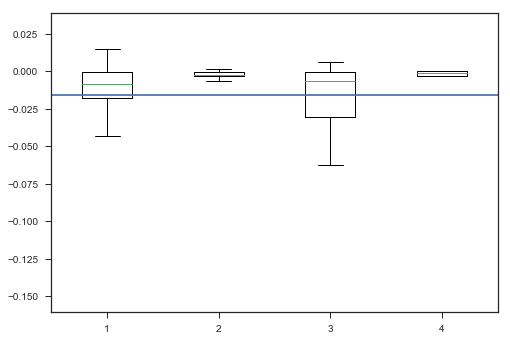

In [54]:
plt.boxplot([rcl[0][0],rcl[0][1],rcl[1][0],rcl[1][1]])

plt.axhline(-np.log(2)/44)

In [53]:
#CMV rates
print('CMV',np.mean(np.append(rcl[0][0],rcl[1][0])),np.std(np.append(rcl[0][0],rcl[1][0])))

#HIV rates
print('HIV',np.mean(np.append(rcl[0][1],rcl[1][1])),np.std(np.append(rcl[0][1],rcl[1][1])))

CMV -0.015630371732489677 0.027149217208730498
HIV -0.0030301935182166476 0.004686757616797171
